# Week 4 Discussion: SVM: The Impact of Penalty Parameters

## Objectives

In this week's discussion, we will learn:
* How to build SVM models
* SVM penalty parameter cross validation
* How to save results to prevent redoing same computations
* Effect of normalization

## Sources

This discussion on SVMs is partly based on p. 79-99 of "Foundations of Machine Learning" by Mehryar Mohri, Afshin Rostamizadeh, and Ameet Talwalkar. 

## Preparing the Data

Before importing the data, as usual, we import _pandas_ library to simplify data manipulation.

In [20]:
import pandas as pd

In this discussion, similar to the previous discussion, we use _Hitters_ dataset which is the data collected from Major League Baseball (MLB) data from the 1986 and 1987 seasons. We want to predict the new league of each player at the end of the season based on their performance in the previous league. For more information on the dataset, please look it up!

In [21]:
#the data can be downloaded from "https://github.com/jcrouser/islr-python/blob/master/data/Hitters.csv"
df = pd.read_csv('Hitters.csv')

We now print out the dataset to gain more insight in it:

In [22]:
print (df.head(10))

              Player  AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  \
0     -Andy Allanson    293    66      1    30   29     14      1     293   
1        -Alan Ashby    315    81      7    24   38     39     14    3449   
2       -Alvin Davis    479   130     18    66   72     76      3    1624   
3      -Andre Dawson    496   141     20    65   78     37     11    5628   
4  -Andres Galarraga    321    87     10    39   42     30      2     396   
5   -Alfredo Griffin    594   169      4    74   51     35     11    4408   
6         -Al Newman    185    37      1    23    8     21      2     214   
7   -Argenis Salazar    298    73      0    24   24      7      3     509   
8     -Andres Thomas    323    81      6    26   32      8      2     341   
9    -Andre Thornton    401    92     17    49   66     65     13    5206   

   CHits    ...      CRuns  CRBI  CWalks  League Division PutOuts  Assists  \
0     66    ...         30    29      14       A        E     446       33

For imputation, similar to the past week, we remove all the rows containing any missing values.

# Handling the Missing Data, the Easy Version

In [23]:
df.dropna(inplace=True)

As discussed above, the _new leage_ column in the dataset will be our label and others will be our features. We select all the columns, except for _NewLeague_, as our features and select _NewLeague_ as our label.

In [24]:
X = df[['AtBat','Hits','HmRun','Runs','RBI','Walks','Years','CAtBat','CHits','CHmRun','CRuns','CRBI','CWalks','League','Division','PutOuts','Assists','Errors','Salary']]
y = df[['NewLeague']]

Then, we do one-hot encoding to get the final stage of features:

In [25]:
X_cat = X.select_dtypes(exclude=['int64', 'float64'])                                                                                                         
X_dog = X.select_dtypes(include=['int64', 'float64'])                                                                                                         
                                                                                                                                                              
X_cat = pd.get_dummies(X_cat)                                                                                                                                 
X = pd.concat([X_cat, X_dog], axis=1)   

In [26]:
X

,League_A,League_N,Division_E,Division_W,AtBat,Hits,HmRun,Runs,RBI,Walks,...,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary
1,0,1,0,1,315,81,7,24,38,39,...,3449,835,69,321,414,375,632,43,10,475.000
2,1,0,0,1,479,130,18,66,72,76,...,1624,457,63,224,266,263,880,82,14,480.000
3,0,1,1,0,496,141,20,65,78,37,...,5628,1575,225,828,838,354,200,11,3,500.000
4,0,1,1,0,321,87,10,39,42,30,...,396,101,12,48,46,33,805,40,4,91.500
5,1,0,0,1,594,169,4,74,51,35,...,4408,1133,19,501,336,194,282,421,25,750.000
6,0,1,1,0,185,37,1,23,8,21,...,214,42,1,30,9,24,76,127,7,70.000
7,1,0,0,1,298,73,0,24,24,7,...,509,108,0,41,37,12,121,283,9,100.000
8,0,1,0,1,323,81,6,26,32,8,...,341,86,6,32,34,8,143,290,19,75.000
9,1,0,1,0,401,92,17,49,66,65,...,5206,1332,253,784,890,866,0,0,0,1100.000
10,1,0,1,0,574,159,21,107,75,59,...,4631,1300,90,702,504,488,238,445,22,517.143


As discussed last week, changing the name of the outputs to numbers from $0$ to $k-1$ with $k$ being the number of different classes we have:

In [27]:
NewLeague2number_dict = {
    'A':0,
    'N':1
}

y=y.replace({"NewLeague": NewLeague2number_dict})

## A Short Recap on SVM

In our linear classification problem, considering our input space a subset of $\mathbb{R}^N$ with $N\geq1$, our hypothesis set $H$ consists of hyperplanes which can be defined as:

$$
H = \{x\rightarrow sign(w.x+b): w \in \mathbb{R}^N,b \in \mathbb{R}\}
$$

A hypothesis of this form labels positively all the points lying on one side, while labeling the others negatively.

### General Non-separable Case

In the general case where the data points are non-separable, the constraints imposed on the model by each data point can be written as:
<br>
$$
\exists \xi_i \mid y_i(w.x_i+b)\geq 1-\xi_i
$$
Therefore, the optimization problem would be:
<br>
$$
\underset{w,b,\xi}{min} \;\; \frac{1}{2}{\|w\|}^2 + C\sum_{n=1}^{m}\xi_i \\
\text{subject to:} \;\; y_i(w.x_i+b)\geq 1-\xi_i \; \wedge  \; \xi_i \geq 0, \; i \in [m]
$$

## Cross-validating $C$ Values

As mentioned in the class, the variable $C$ in the loss function above is a hyperparameter to be determined in cross-validation. In the code snippet below, we define a function named _cross validate c vals_ which inputs data consisting of $X$ and $y$, a vector of different values of $C$, and the number of folds for the cross-validation. For each value of $C$, it performs cross-validation independantly and outputs a dictionary which contains the values of AUROC for all the values of $C$ in the vector. 

In [28]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

def cross_validate_c_vals(X, y, c_vals, n_folds):
    
    c_auc_dict = {}

    for c in c_vals:
        c_auc_dict[c] = 0
        skf=StratifiedKFold(n_splits=n_folds, shuffle=True)
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()

            svm = SVC(C=c, kernel="linear", shrinking=False)
            
            svm.fit(X_train, y_train)

            pred   =   svm.predict(X_test)

            c_auc_dict[c]   += roc_auc_score(y_test, pred)/n_folds
        
    return c_auc_dict

## Saving Results: A Way to Save Time

In many applications of machine learning, the task at hand can be computationally expensive. SVM, for example, is one of the algorithms that based on the data size and the penalty parameter, can take a while to train. Therefore, it would be of considerable importance to save the results of some computations so they should not be redone later. 

Here, we put all the results in a directory with the same name. In the following piece of code, we first check if it exists, and if not, we will create it:

In [29]:
import os

rslt_addr = "./results/Bdlaskndsal/"
rslt_addr = "./results/"
if not os.path.exists(rslt_addr):
    os.makedirs(rslt_addr)

As mentioned, it would be desirable to save the computations. In order to do this, we choose a file name for our results under which it would be saved. We will see shortly how it will be used. The second line of code, appends the file name to the address we had for all the results to give us the address to the result file.
<br>
One of the common ways of saving objects on file in Python is using _pickle_ library. Here we show an example of using it but for more information please refer to the documentation available online.

In [30]:
rslt_dict_name = "svm_results.pickle"
rslt_dict_addr = os.path.join(rslt_addr, rslt_dict_name)

## Performing the Computation if Necessary

In this piece of code, we first define the values of $C$ we wand to perform the cross-validation on as well as the number of folds. We then check if the file name of the results exits, and if it does, we read the result from there, without ever doing the computation. If not, we call the _cross validate c vals_ function to generate the results and then save it to a file with the file name determined earlier therefore we do not end up doing the same computation later.
<br>
It should also be noted that the naming could be done in a better fashion to reflect the content more accurately. For example, the file name does not reflect the exact values of $C$ which have been cross-validated or the number of folds. Therefore, a better naming convention would contain that information in the file name as well.

In [31]:
import numpy as np
import pickle

c_vals = np.power(float(10), range(-3, 3 + 1))
n_folds = 5

if os.path.isfile(rslt_dict_addr):
    with open(rslt_dict_addr,"rb") as rslt_dict_handle:
        c_auc_dict = pickle.load(rslt_dict_handle)
else:
    c_auc_dict = cross_validate_c_vals(X, y, c_vals, n_folds)
    with open(rslt_dict_addr,"wb") as rslt_dict_handle:
        pickle.dump(c_auc_dict, rslt_dict_handle)

By printing out the results, we have:

In [32]:
print (c_auc_dict)

{0.001: 0.606568144499179, 0.01: 0.889064039408867, 0.1: 0.9319885057471264, 1.0: 0.8849490968801315, 10.0: 0.8533571428571429, 100.0: 0.8724367816091954, 1000.0: 0.8685952380952382}


## Defining a Function for Plotting ROC Against $C$

The function defined below plots the auc of different $C$ values and their corresponding auc in a bar plot.

In [33]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
import numpy as np

def plot_roc(c_vals, c_auc_dict, y_lims):
    plt.figure(figsize = (16,10)) 

    plt.bar(range(len(c_vals)), [c_auc_dict[c_val] for c_val in c_vals], color='black')

    plt.title('SVM ROC for Penalty Parameter C')
    plt.xlabel('C')
    plt.ylim(y_lims[0], y_lims[1])
    plt.ylabel('ROC')
    plt.xticks(range(len(c_vals)), c_vals, rotation='vertical')
    plt.show()

Plotting the results obtained for ROC of SVM using the penalty parameters $C$ we have:

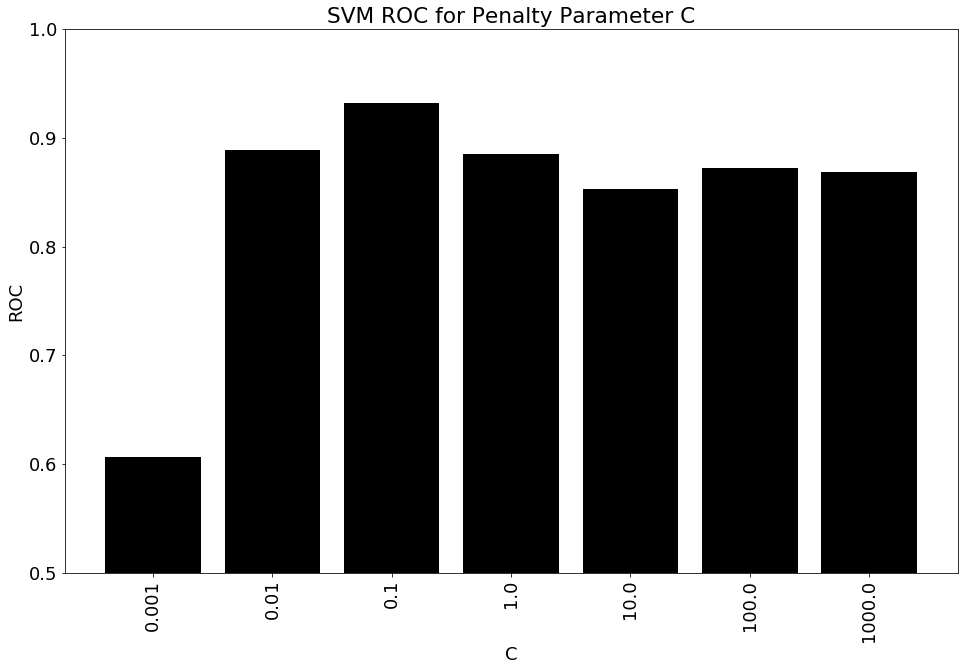

In [34]:
plot_roc(c_vals, c_auc_dict, [0.5,1])

## Effect of Normalization in SVM Optimization

Here, we normalize the data before feeding it to the SVM and we put the results in a new file name:

In [35]:
nrml_rslt_dict_name = "nrml_svm_results.pickle"
nrml_rslt_dict_addr = os.path.join(rslt_addr, nrml_rslt_dict_name)

In [36]:
from sklearn.preprocessing import normalize

X = pd.DataFrame(normalize(X))

n_folds = 5
c_vals = c_vals = np.power(float(10), range(-7, 10 + 1))

if os.path.isfile(nrml_rslt_dict_addr):
    with open(nrml_rslt_dict_addr,"rb") as nrml_rslt_dict_handle:
        c_auc_dict = pickle.load(nrml_rslt_dict_handle)

else:
    c_auc_dict = cross_validate_c_vals(X, y, c_vals, n_folds)
            
    with open(nrml_rslt_dict_addr,"wb") as nrml_rslt_dict_handle:
        pickle.dump(c_auc_dict, nrml_rslt_dict_handle)

Printing out the results, we have:

In [37]:
c_auc_dict

{1e-07: 0.5,
 1e-06: 0.5,
 1e-05: 0.5,
 0.0001: 0.5,
 0.001: 0.5,
 0.01: 0.5,
 0.1: 0.5,
 1.0: 0.519055829228243,
 10.0: 0.4920878489326765,
 100.0: 0.5168423645320197,
 1000.0: 0.5677873563218391,
 10000.0: 0.6511313628899835,
 100000.0: 0.8432586206896552,
 1000000.0: 0.8989367816091953,
 10000000.0: 0.846512315270936,
 100000000.0: 0.8696830870279146,
 1000000000.0: 0.8320008210180624,
 10000000000.0: 0.8709532019704435}

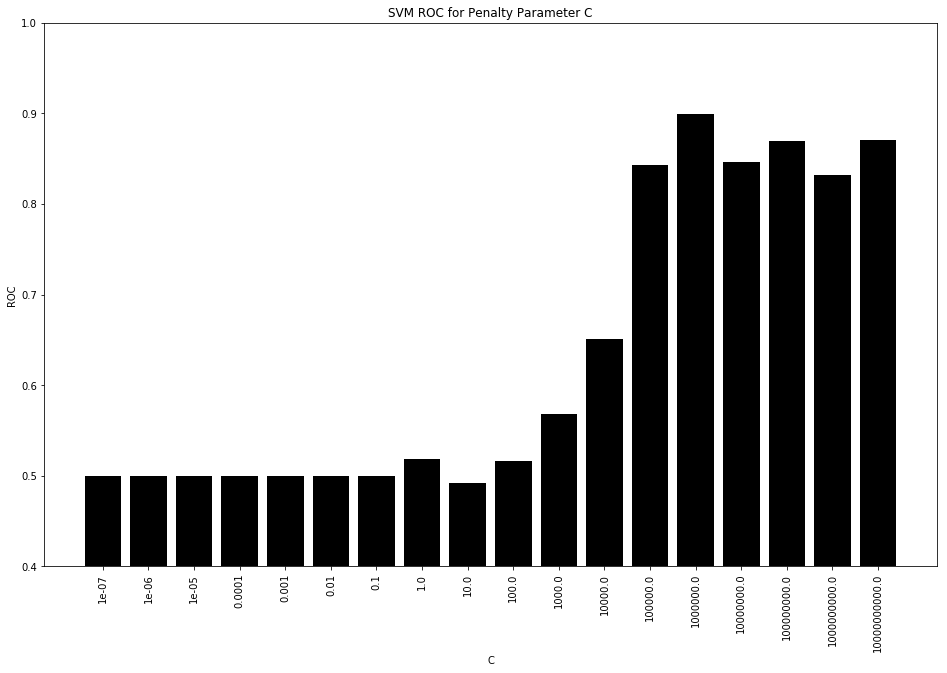

In [19]:
plot_roc(c_vals, c_auc_dict, [0.4,1])

As can be seen, the best value for $C$ has changed drastically. The reasoning lies in the fact that the data gets more compact therefore the slack variables become smaller. Therefore, there is a need for a larger $C$ to still make sure they are minimized as much as desired. The discussion found [here](https://stats.stackexchange.com/questions/31066/what-is-the-influence-of-c-in-svms-with-linear-kernel) is also helpful.